In [106]:
import cudf
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn. preprocessing import OneHotEncoder
from lifelines import CoxPHFitter, WeibullAFTFitter, LogNormalAFTFitter, AalenAdditiveFitter
from sklearn.base import BaseEstimator
import itertools
from catboost import CatBoostClassifier,CatBoostRegressor,Pool,cv

In [2]:
transaction_data = cudf.read_csv('./transactions.csv',parse_dates=['transaction_dttm'])
clients_data = cudf.read_csv('./clients.csv')
train_data = cudf.read_csv('./train.csv')
report_data = cudf.read_csv('./report_dates.csv')
simple_sol = cudf.read_csv('./sample_submit_naive.csv')
reports_data = cudf.read_csv('report_dates.csv',parse_dates=['report_dt'])

In [4]:
clients_data_merge = clients_data.merge(reports_data)[['report_dt','user_id']]
transaction_data = transaction_data.merge(clients_data_merge)

In [5]:
transaction_data.groupby('user_id').agg('count')['transaction_dttm'].mean()

136.19815625

In [6]:
transaction_data

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,report_dt
0,800,8,1,-650.339844,2022-08-30 14:41:03,2023-02-28 03:00:00
1,800,15,1,-658.876404,2022-08-30 18:04:29,2023-02-28 03:00:00
2,800,1,1,-167.267731,2022-08-30 18:20:42,2023-02-28 03:00:00
3,800,15,1,-127.436165,2022-08-31 15:40:43,2023-02-28 03:00:00
4,800,3,1,-4534.637207,2022-08-31 16:55:34,2023-02-28 03:00:00
...,...,...,...,...,...,...
13075018,559253,3,1,-90.221107,2023-03-01 18:14:39,2023-06-30 03:00:00
13075019,559253,3,1,-186.262100,2023-03-02 13:07:48,2023-06-30 03:00:00
13075020,559253,3,1,-92.112129,2023-03-10 18:07:37,2023-06-30 03:00:00
13075021,559253,3,1,-92.357025,2023-03-15 12:05:27,2023-06-30 03:00:00


In [7]:
def mounth_count_day(x):
    mounths = [31,28,31,30,31,30,31,31,30,31,30,31]
    return sum(mounths[:x])

def create_time_features(df):
    df['month'] = df['transaction_dttm'].dt.month
    df['day'] = df['transaction_dttm'].dt.day
    df['week'] = df['transaction_dttm'].dt.day.map(lambda x: x // 7)
    df['minute'] = df['transaction_dttm'].dt.minute
    df['second'] = df['transaction_dttm'].dt.second
    df['month_count'] = df['transaction_dttm'].dt.month.map(lambda x: 30 * x)
    df['hour'] = df['transaction_dttm'].dt.hour
    df['year'] = df['transaction_dttm'].dt.year
    
    df['weekofyear'] = df['transaction_dttm'].dt.dayofyear.map(lambda x: x // 7)
    df['dayofweek'] = df['transaction_dttm'].dt.dayofweek
    df['all_day_time'] = df.apply(lambda x:x.hour * 3600 + x.minute * 60 + x.second)
    df['all_week_time'] = df.apply(lambda x:x.dayofweek * 24 + x.hour)
    df['all_year_time'] = df.apply(lambda x: x.month_count + x.day + x.hour / 24)
    df['all_time'] = df.apply(lambda x:(x.year - 2021)*365 + x.month_count + x.day + x.hour / 24)
    df['all_month_time'] = df.apply(lambda x:x.day * 24 + x.hour + x.minute / 60)
    df['all_sec_time'] = df.apply(lambda x: (x.year - 2021)*365 * 24 * 3600 + x.month * 30 * 24 * 3600 + x.day * 24 * 3600 + x.hour * 3600 + x.minute * 60 + x.second)
    df['all_sec_time_report'] = (df['report_dt'].dt.year - 2021)*365 * 24 * 3600 + df['report_dt'].dt.month * 30 * 24 * 3600 + df['report_dt'].dt.day * 24 * 3600 + df['report_dt'].dt.hour * 3600 + df['report_dt'].dt.minute * 60 + df['report_dt'].dt.second
    df['delta_all_sec_time'] = df['all_sec_time_report'] - df['all_sec_time']
    df['hour_time'] = df.apply(lambda x:x.minute * 60 + x.second)

    df['cl_early_morning'] = ((df['hour'] > 4) & (df['hour'] <= 8)).astype('int16')
    df['cl_is_weekend'] = (df['dayofweek'] > 4).astype('int16')
    return df

In [8]:
transaction_data = create_time_features(transaction_data)

In [9]:
transaction_data

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,report_dt,month,day,week,minute,...,all_week_time,all_year_time,all_time,all_month_time,all_sec_time,all_sec_time_report,delta_all_sec_time,hour_time,cl_early_morning,cl_is_weekend
0,800,8,1,-650.339844,2022-08-30 14:41:03,2023-02-28 03:00:00,8,30,4,41,...,38,270.583333,635.583333,734.683333,54916863,70686000,15769137,2463,0,0
1,800,15,1,-658.876404,2022-08-30 18:04:29,2023-02-28 03:00:00,8,30,4,4,...,42,270.750000,635.750000,738.066667,54929069,70686000,15756931,269,0,0
2,800,1,1,-167.267731,2022-08-30 18:20:42,2023-02-28 03:00:00,8,30,4,20,...,42,270.750000,635.750000,738.333333,54930042,70686000,15755958,1242,0,0
3,800,15,1,-127.436165,2022-08-31 15:40:43,2023-02-28 03:00:00,8,31,4,40,...,63,271.625000,636.625000,759.666667,55006843,70686000,15679157,2443,0,0
4,800,3,1,-4534.637207,2022-08-31 16:55:34,2023-02-28 03:00:00,8,31,4,55,...,64,271.666667,636.666667,760.916667,55011334,70686000,15674666,3334,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13075018,559253,3,1,-90.221107,2023-03-01 18:14:39,2023-06-30 03:00:00,3,1,0,14,...,66,91.750000,821.750000,42.233333,71000079,81226800,10226721,879,0,0
13075019,559253,3,1,-186.262100,2023-03-02 13:07:48,2023-06-30 03:00:00,3,2,0,7,...,85,92.541667,822.541667,61.116667,71068068,81226800,10158732,468,0,0
13075020,559253,3,1,-92.112129,2023-03-10 18:07:37,2023-06-30 03:00:00,3,10,1,7,...,114,100.750000,830.750000,258.116667,71777257,81226800,9449543,457,0,0
13075021,559253,3,1,-92.357025,2023-03-15 12:05:27,2023-06-30 03:00:00,3,15,2,5,...,60,105.500000,835.500000,372.083333,72187527,81226800,9039273,327,0,0


In [10]:
transaction_data#.groupby('user_id')

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,report_dt,month,day,week,minute,...,all_week_time,all_year_time,all_time,all_month_time,all_sec_time,all_sec_time_report,delta_all_sec_time,hour_time,cl_early_morning,cl_is_weekend
0,800,8,1,-650.339844,2022-08-30 14:41:03,2023-02-28 03:00:00,8,30,4,41,...,38,270.583333,635.583333,734.683333,54916863,70686000,15769137,2463,0,0
1,800,15,1,-658.876404,2022-08-30 18:04:29,2023-02-28 03:00:00,8,30,4,4,...,42,270.750000,635.750000,738.066667,54929069,70686000,15756931,269,0,0
2,800,1,1,-167.267731,2022-08-30 18:20:42,2023-02-28 03:00:00,8,30,4,20,...,42,270.750000,635.750000,738.333333,54930042,70686000,15755958,1242,0,0
3,800,15,1,-127.436165,2022-08-31 15:40:43,2023-02-28 03:00:00,8,31,4,40,...,63,271.625000,636.625000,759.666667,55006843,70686000,15679157,2443,0,0
4,800,3,1,-4534.637207,2022-08-31 16:55:34,2023-02-28 03:00:00,8,31,4,55,...,64,271.666667,636.666667,760.916667,55011334,70686000,15674666,3334,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13075018,559253,3,1,-90.221107,2023-03-01 18:14:39,2023-06-30 03:00:00,3,1,0,14,...,66,91.750000,821.750000,42.233333,71000079,81226800,10226721,879,0,0
13075019,559253,3,1,-186.262100,2023-03-02 13:07:48,2023-06-30 03:00:00,3,2,0,7,...,85,92.541667,822.541667,61.116667,71068068,81226800,10158732,468,0,0
13075020,559253,3,1,-92.112129,2023-03-10 18:07:37,2023-06-30 03:00:00,3,10,1,7,...,114,100.750000,830.750000,258.116667,71777257,81226800,9449543,457,0,0
13075021,559253,3,1,-92.357025,2023-03-15 12:05:27,2023-06-30 03:00:00,3,15,2,5,...,60,105.500000,835.500000,372.083333,72187527,81226800,9039273,327,0,0


In [11]:
def generate_time_features(df): ## ADD cnt / (max - min)
    time_day_features = df.groupby('user_id')['all_day_time'].agg(['mean', 'std', 'min', 'max', 'median','count'])
    time_day_features.columns = [f'time_day_features_{c}' for c in time_day_features.columns]
    time_day_features['time_day_features_diff'] = time_day_features['time_day_features_max'] - time_day_features['time_day_features_min']
    
    all_sec_features = df.groupby('user_id')['all_sec_time'].agg(['mean', 'std', 'min', 'max', 'median','count','var',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)])
    all_sec_features.columns = [f'all_sec_time_features_{c}' for c in all_sec_features.columns]
    all_sec_features['all_sec_time_features_diff'] = all_sec_features['all_sec_time_features_max'] - all_sec_features['all_sec_time_features_min']
    all_sec_features['all_sec_time_scale'] = all_sec_features['all_sec_time_features_mean'] - all_sec_features['all_sec_time_features_median']
    
    delta_all_sec_features = df.groupby('user_id')['delta_all_sec_time'].agg(['mean', 'std', 'min', 'max', 'median','count','var',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)])
    delta_all_sec_features.columns = [f'delta_all_sec_time_features_{c}' for c in delta_all_sec_features.columns]
    delta_all_sec_features['delta_all_sec_features_diff'] = delta_all_sec_features['delta_all_sec_time_features_max'] - delta_all_sec_features['delta_all_sec_time_features_min']
    delta_all_sec_features['delta_all_sec_features_scale'] = delta_all_sec_features['delta_all_sec_time_features_mean'] - delta_all_sec_features['delta_all_sec_time_features_median']


    time_year_featues = df.groupby('user_id')['all_year_time'].agg(['mean', 'std', 'min', 'max', 'median',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75),'count'])
    time_year_featues.columns = [f'time_year_featues_{c}' for c in time_year_featues.columns]
    time_year_featues['time_year_featues_diff'] = time_year_featues['time_year_featues_max'] - time_year_featues['time_year_featues_min']
    time_year_featues['time_year_featues_interval'] = time_year_featues['time_year_featues_count'] / time_year_featues['time_year_featues_diff']  
    

    all_time_featues = df.groupby('user_id')['all_time'].agg(['mean', 'std', 'min', 'max','count','median'])
    all_time_featues.columns = [f'all_time_featues_{c}' for c in all_time_featues.columns]
    all_time_featues['all_time_featues_diff'] = all_time_featues['all_time_featues_count'] / (all_time_featues['all_time_featues_max'] - all_time_featues['all_time_featues_min'])

    time_month_features = df.groupby('user_id')['all_month_time'].agg(['mean', 'std', 'min', 'max', 'median'])
    time_month_features.columns = [f'time_month_features_{c}' for c in time_month_features.columns]
    time_month_features['time_month_features_diff'] = time_month_features['time_month_features_max'] - time_month_features['time_month_features_min']


    dayofweek_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['transaction_amt'],
                             columns=['dayofweek'],
                             aggfunc=['count','mean','max','std','min']).fillna(0).sort_index() # 'median','sum'
    
    hour_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['transaction_amt'],
                             columns=['hour'],
                             aggfunc=['count','mean','max','std','min',]).fillna(0).sort_index()
    

    month_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['transaction_amt'],
                             columns=['month'],
                             aggfunc=['count','mean','max','std','min']).fillna(0).sort_index()
    
    dayofweek_embeds = cudf.DataFrame(dayofweek_embeds.values)
    hour_embeds = cudf.DataFrame(hour_embeds.values)
    month_embeds = cudf.DataFrame(month_embeds.values)
    
    dayofweek_embeds.columns = [f'dayofweek_embeds_{i}' for i in dayofweek_embeds.columns]
    hour_embeds.columns = [f'hour_embeds_{i}' for i in hour_embeds.columns]
    month_embeds.columns = [f'month_embeds_{i}' for i in month_embeds.columns]
    
    dayofweek_embeds.index = time_day_features.index
    hour_embeds.index = time_day_features.index
    month_embeds.index = time_day_features.index

    
    time_feartures = cudf.concat([time_day_features.sort_index(),
                                time_year_featues.sort_index(),
                                delta_all_sec_features.sort_index(),
                                time_month_features.sort_index(),
                                all_time_featues.sort_index(),
                                all_sec_features.sort_index(),
                                dayofweek_embeds,
                                hour_embeds,
                                month_embeds],axis=1)

    return time_feartures

In [12]:
def generate_time_features_factors(df,idx):
    df['operations_type'] = df['transaction_amt'].map(lambda x: 1 if x >= 0 else 0)
    
    all_sec_oper_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['all_sec_time'],
                             columns=['operations_type'],
                             aggfunc=['mean', 'std', 'min', 'max', 'median','count','var',
                                      lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]).fillna(0).sort_index()
    
    all_month_oper_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['all_month_time'],
                             columns=['operations_type'],
                             aggfunc=['mean', 'std', 'min', 'max', 'median','count','var',
                                      lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]).fillna(0).sort_index()
        
    all_day_oper_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['all_day_time'],
                             columns=['operations_type'],
                             aggfunc=['mean', 'std', 'min', 'max', 'median','count','var',
                                      lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]).fillna(0).sort_index()
    
    
    all_sec_oper_embeds = cudf.DataFrame(all_sec_oper_embeds.values)
    all_month_oper_embeds = cudf.DataFrame(all_month_oper_embeds.values)
    all_day_oper_embeds = cudf.DataFrame(all_day_oper_embeds.values)
    
    all_sec_oper_embeds.columns = [f'all_sec_oper_embeds_{i}' for i in all_sec_oper_embeds.columns]
    all_month_oper_embeds.columns = [f'all_month_oper_embeds_{i}' for i in all_month_oper_embeds.columns]
    all_day_oper_embeds.columns = [f'all_day_oper_embeds_{i}' for i in all_day_oper_embeds.columns]
    
    all_sec_oper_embeds.index = idx
    all_month_oper_embeds.index = idx
    all_day_oper_embeds.index = idx                         

    time_feartures = cudf.concat([all_sec_oper_embeds,
                                 all_month_oper_embeds,
                                 all_day_oper_embeds],axis=1)

    return time_feartures

In [13]:
def get_corr_cov_features(df):
    feat_year_time_corr_ps = df[['transaction_amt','all_sec_time','user_id']].groupby('user_id').corr('pearson')
    feat_year_time_corr_ps = feat_year_time_corr_ps.values[:,1][::2]
    #feat_year_time_corr_sp = df[['transaction_amt','all_time','user_id']].groupby('user_id').corr('spearman')
    #feat_year_time_corr_sp = feat_year_time_corr_sp.values[:,1][::2]
    
    feat_hour_corr_ps = df[['transaction_amt','hour','user_id']].groupby('user_id').corr('pearson')
    feat_hour_corr_ps = feat_hour_corr_ps.values[:,1][::2]
    #feat_hour_corr_sp = df[['transaction_amt','hour','user_id']].groupby('user_id').corr('spearman')
    #feat_hour_corr_sp = feat_hour_corr_sp.values[:,1][::2]
    
    feat_dayofweek_corr_ps = df[['transaction_amt','dayofweek','user_id']].groupby('user_id').corr('pearson')
    feat_dayofweek_corr_ps = feat_dayofweek_corr_ps.values[:,1][::2]
    #feat_dayofweek_corr_sp = df[['transaction_amt','dayofweek','user_id']].groupby('user_id').corr('spearman')
    #feat_dayofweek_corr_sp = feat_dayofweek_corr_sp.values[:,1][::2]
    
    feat_year_time_cov = df[['transaction_amt','all_sec_time','user_id']].groupby('user_id').cov()
    feat_year_time_cov_0 = feat_year_time_cov.values[:,1][::2]
    feat_year_time_cov_1 = feat_year_time_cov.values[:,0][::2]
    
    feat_hour_cov = df[['transaction_amt','hour','user_id']].groupby('user_id').cov()
    feat_hour_cov_0 = feat_year_time_cov.values[:,1][::2]
    feat_hour_cov_1 = feat_year_time_cov.values[:,0][::2]    

    feat_dayofweek_cov = df[['transaction_amt','dayofweek','user_id']].groupby('user_id').cov()
    feat_dayofweek_cov_0 = feat_year_time_cov.values[:,1][::2]
    feat_dayofweek_cov_1 = feat_year_time_cov.values[:,0][::2]    
    
    feature_df = cudf.DataFrame({'feat_year_time_corr_ps':feat_year_time_corr_ps,
                               #'feat_year_time_corr_sp':feat_year_time_corr_sp,
                               'feat_hour_corr_ps':feat_hour_corr_ps,
                               #'feat_hour_corr_sp':feat_hour_corr_sp,
                               'feat_dayofweek_corr_ps':feat_dayofweek_corr_ps,
                               #'feat_dayofweek_corr_sp':feat_dayofweek_corr_sp,
                               'feat_year_time_cov_0':feat_year_time_cov_0,
                               'feat_year_time_cov_1':feat_year_time_cov_1,
                               'feat_hour_cov_0':feat_hour_cov_0,
                               'feat_hour_cov_1':feat_hour_cov_1,
                               'feat_dayofweek_cov_0':feat_dayofweek_cov_0,
                               'feat_dayofweek_cov_1':feat_dayofweek_cov_1})
    return feature_df

In [14]:
time_features = generate_time_features(transaction_data)
corr_features = get_corr_cov_features(transaction_data)
time_features_oper = generate_time_features_factors(transaction_data,time_features.index)
corr_features.index = time_features.index

In [15]:
def prepare_mcc(df):
    value_counts = transaction_data['mcc_code'].value_counts()
    important_mcc = value_counts[value_counts > 40_000].index.values.tolist()
    df['important_mcc'] = [x if x in important_mcc else -1 for x in df['mcc_code'].to_pandas()]
    return df

transaction_data = prepare_mcc(transaction_data)

In [16]:
def make_money_features(df):
    simple_features = df.groupby('user_id')['transaction_amt'].agg(['mean', 'std', 'min', 'max', 'median','sum',lambda x:x.quantile(0.25),lambda x: x.quantile(0.75)])
    simple_features.columns = [f'simple_features_{c}' for c in simple_features.columns]
    simple_features['simple_features_diff'] = simple_features['simple_features_max'] - simple_features['simple_features_min']
    simple_features['simple_features_step'] =  simple_features['simple_features_mean'] / simple_features['simple_features_diff']
    
    month_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['transaction_amt'],
                             columns=['important_mcc'],
                             aggfunc=['count','mean','max','std','min','median']).fillna(0).sort_index()
    
    df['currency_rk'] = df['currency_rk'].apply(lambda x: 0 if x > 1 else x)
    curr_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['transaction_amt'],
                             columns=['currency_rk'],
                             aggfunc=['count','mean','max','std','min','median']).fillna(0).sort_index()

    
    month_embeds = cudf.DataFrame(month_embeds.values)
    month_embeds.columns = [f'mony_embeds_{i}' for i in month_embeds.columns]
    month_embeds.index = simple_features.index
    
    curr_embeds = cudf.DataFrame(curr_embeds.values)
    curr_embeds.columns = [f'curr_embeds_{i}' for i in curr_embeds.columns]
    curr_embeds.index = simple_features.index

    
    money_features = cudf.concat([simple_features.sort_index(),
                                curr_embeds,month_embeds],axis=1)

    return money_features

def make_money_features_factors(df):
    df['operations_type'] = df['transaction_amt'].map(lambda x: 1 if x >= 0 else 0)
    df['transaction_amt_abs'] = df['transaction_amt'].abs()
    simple_features = df.groupby('user_id')['operations_type'].agg(['mean', 'std', 'min', 'max', 'median'])
    simple_features.columns = [f'simple_opr_features_{c}' for c in simple_features.columns]
    
    simple_oper_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['transaction_amt_abs'],
                             columns=['operations_type'],
                             aggfunc=['count','mean','max','std','min','median']).fillna(0).sort_index()

    mcc_oper_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['transaction_amt_abs'],
                             columns=['important_mcc','operations_type'],
                             aggfunc=['count','mean','max','std','min','median']).fillna(0).sort_index()
    
    mcc_oper_embeds = cudf.DataFrame(mcc_oper_embeds.values)
    mcc_oper_embeds.columns = [f'mony_oper_embeds_{i}' for i in mcc_oper_embeds.columns]
    mcc_oper_embeds.index = simple_features.index
    
    simple_oper_embeds = cudf.DataFrame(simple_oper_embeds.values)
    simple_oper_embeds.columns = [f'simple_oper_embeds_{i}' for i in simple_oper_embeds.columns]
    simple_oper_embeds.index = simple_features.index

    
    money_features = cudf.concat([simple_features.sort_index(),
                                mcc_oper_embeds,simple_oper_embeds],axis=1)

    return money_features

In [17]:
def time_mcc_features(df,idxes):
    
    time_mcc_embeds = cudf.pivot_table(
                             transaction_data,
                             index =['user_id'],
                             values=['all_year_time'],
                             columns=['important_mcc','operations_type'],
                             aggfunc=['mean','max','std','min','median']).fillna(-1).sort_index()
    
    time_mcc_embeds = cudf.DataFrame(time_mcc_embeds.values)
    time_mcc_embeds.columns = [f'time_mcc_embeds_{i}' for i in time_mcc_embeds.columns]
    time_mcc_embeds.index = idxes
    
    return time_mcc_embeds

def distance_calc_step_5(x,step=5):
    dist = []
    num_steps = len(x) // 5 -1
    for i in range(num_steps):
        dist += [sum(x[i*5:(i+1)*5]) - sum(x[(i+1)*5:(i+2)*5])]
    
    if dist == []:
        return [-1,-1]
    return dist

def distance_calc(x):
    dist = []
    for i in range(len(x)-1):
        dist += [x[i+1] - x[i]]
    return dist

def calc_corr_synth(x):
    return cudf.DataFrame({'feature':x,'idx':range(len(x))}).corr()['feature']['idx']
    
def polifit_second(x):
    if len(x) % 2 == 0:
        return np.polyfit(range(len(x) // 2), x[len(x) // 2:], 1)[1]
    else:
        return np.polyfit(range(len(x) // 2 + 1), x[len(x) // 2:], 1)[1]


def shift_features(df,shifter_f=distance_calc):
    df_pandas = df[['user_id','all_sec_time']].to_pandas()
    
    times_featues = df_pandas.groupby('user_id').agg(lambda x:sorted(x.tolist()))
    times_featues['distances'] = times_featues['all_sec_time'].map(shifter_f)
    
    feature_df = cudf.DataFrame()
    feature_df['time_step_max'] = times_featues['distances'].progress_map(np.max)
    feature_df['time_step_min'] = times_featues['distances'].progress_map(np.min)
    feature_df['time_step_mean'] = times_featues['distances'].progress_map(np.mean)
    feature_df['time_step_std'] = times_featues['distances'].progress_map(np.std)
    feature_df['time_step_median'] = times_featues['distances'].progress_map(np.median)
    feature_df['time_step_q_25'] = times_featues['distances'].progress_map(lambda x:np.quantile(x,0.75))
    feature_df['time_step_q_75'] = times_featues['distances'].progress_map(lambda x:np.quantile(x,0.25))
    #feature_df['time_step_q_55'] = times_featues['distances'].progress_map(lambda x:np.quantile(x,0.55))
    #feature_df['time_step_q_45'] = times_featues['distances'].progress_map(lambda x:np.quantile(x,0.45))
    #feature_df['synth_corr'] = times_featues['distances'].progress_map(calc_corr_synth)
    feature_df['time_step_polyfit'] = times_featues['distances'].progress_map(lambda x:np.polyfit(range(len(x)), x, 1)[1])
    feature_df['time_step_polyfit_st'] = times_featues['distances'].progress_map(lambda x:np.polyfit(range(len(x)), x, 1)[0])
    feature_df['time_step_polyfit_first_per'] = times_featues['distances'].progress_map(lambda x:np.polyfit(range(len(x) // 2), x[:len(x) // 2], 1)[1])
    feature_df['time_step_polyfit_second_per'] = times_featues['distances'].progress_map(polifit_second)
    feature_df['time_step_polyfit_otn'] = feature_df['time_step_polyfit_first_per'] - feature_df['time_step_polyfit_second_per']
    #feature_df['time_step_polyfit_st_2'] = times_featues['distances'].progress_map(lambda x:np.polyfit(range(len(x)), x, 2)[2])
    feature_df.index = times_featues.index.tolist()
    
    return feature_df

In [18]:
def calc_counts_oper_per(x,step=604800):
    x = np.array(x)
    step = (x[-1] - x[0]) / 10
    prep_features = []
    end_val = x[-1]
    step_end = x[0]
    step_sart = -1
    
    while step_end <= end_val:
        step_sart = step_end
        step_end += step
        prep_features += [len(x[(x >= step_sart) & (x <= step_end)])]
    
    return prep_features

def time_brutforce(df):
    df_pandas = df[['user_id','all_sec_time']].to_pandas()
    
    times_featues = df_pandas.groupby('user_id').agg(lambda x:sorted(x.tolist()))
    times_featues['counts'] = times_featues['all_sec_time'].progress_map(calc_counts_oper_per)
    
    feature_df = cudf.DataFrame()
    feature_df['hard_time_step_count'] = times_featues['counts'].progress_map(len)
    feature_df['hard_time_step_max'] = times_featues['counts'].progress_map(np.max)
    feature_df['hard_time_step_min'] = times_featues['counts'].progress_map(np.min)
    feature_df['hard_time_step_mean'] = times_featues['counts'].progress_map(np.mean)
    feature_df['hard_time_step_std'] = times_featues['counts'].progress_map(np.std)
    feature_df['hard_time_step_median'] = times_featues['counts'].progress_map(np.median)
    feature_df['hard_time_step_q_25'] = times_featues['counts'].progress_map(lambda x:np.quantile(x,0.75))
    feature_df['hard_time_step_q_75'] = times_featues['counts'].progress_map(lambda x:np.quantile(x,0.25))
    feature_df['hard_time_step_polyfit'] = times_featues['counts'].progress_map(lambda x:np.polyfit(range(len(x)), x, 1)[1])
    feature_df['hard_time_step_polyfit_st'] = times_featues['counts'].progress_map(lambda x:np.polyfit(range(len(x)), x, 1)[0])
    feature_df.index = times_featues.index.tolist()
    
    return feature_df

In [19]:
tqdm.pandas()

In [20]:
shift_feature = shift_features(transaction_data)

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/96000 [00:00<?, ?it/s]

In [21]:
#shift5_feature = shift_features(transaction_data,shifter_f=distance_calc_step_5)
#shift5_feature.columns = [f'step5_{x}' for x in shift5_feature.columns]

In [22]:
mony_features = make_money_features(transaction_data)
mony_features_v2 = make_money_features_factors(transaction_data)
time_mcc_features = time_mcc_features(transaction_data,mony_features.index)

In [23]:
clients_data = clients_data.set_index('user_id')
all_data = cudf.concat([mony_features,shift_feature,time_features,time_features_oper,clients_data,corr_features],axis=1)
all_data

,simple_features_mean,simple_features_std,simple_features_min,simple_features_max,simple_features_median,simple_features_sum,simple_features_<lambda>,simple_features_diff,simple_features_step,curr_embeds_0,...,customer_age,feat_year_time_corr_ps,feat_hour_corr_ps,feat_dayofweek_corr_ps,feat_year_time_cov_0,feat_year_time_cov_1,feat_hour_cov_0,feat_hour_cov_1,feat_dayofweek_cov_0,feat_dayofweek_cov_1
user_id,,,,,,,,,,,,,,,,,,,,,
3,1246.037876,60860.880477,-153866.890625,104011.960937,4549.455078,13706.416641,16861.306152,257878.851562,0.004832,0.0,...,3,0.574989,0.458957,0.366283,1.230689e+11,3.704047e+09,1.230689e+11,3.704047e+09,1.230689e+11,3.704047e+09
9,-3593.718520,11797.055119,-90147.617188,-45.579891,-840.509674,-323434.666813,-434.467491,90102.037296,-0.039885,0.0,...,3,-0.175412,-0.097424,-0.020805,-9.672813e+09,1.391705e+08,-9.672813e+09,1.391705e+08,-9.672813e+09,1.391705e+08
13,-5668.971780,23507.953991,-58740.300781,70322.828125,-10529.004883,-124717.379150,5211.026978,129063.128906,-0.043924,1.0,...,2,0.043900,0.268719,-0.086992,4.504369e+09,5.526239e+08,4.504369e+09,5.526239e+08,4.504369e+09,5.526239e+08
37,-1053.522538,3913.114835,-35782.984375,5487.140625,-236.420776,-331859.599463,-141.720711,41270.125000,-0.025527,0.0,...,2,0.067023,-0.034972,0.048981,1.031022e+09,1.531247e+07,1.031022e+09,1.531247e+07,1.031022e+09,1.531247e+07
41,-6786.663385,5251.737982,-16841.208984,-290.766998,-6328.293701,-108586.614166,-1537.244461,16550.441986,-0.410059,0.0,...,2,0.451739,0.394066,-0.255335,9.251499e+09,2.758075e+07,9.251499e+09,2.758075e+07,9.251499e+09,2.758075e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562043,-799.493409,2136.038913,-13020.519531,-40.769005,-239.170517,-29581.256115,-102.463661,12979.750526,-0.061595,0.0,...,2,0.370689,0.134854,-0.141449,1.363412e+09,4.562662e+06,1.363412e+09,4.562662e+06,1.363412e+09,4.562662e+06
562205,-268.158335,590.682233,-6220.171387,1595.461060,-147.305283,-40491.908630,-27.259905,7815.632446,-0.034311,0.0,...,1,-0.197103,-0.043995,-0.094764,-5.107548e+08,3.489055e+05,-5.107548e+08,3.489055e+05,-5.107548e+08,3.489055e+05
562312,-331.032523,309.587795,-1372.377075,-28.292030,-271.973526,-18537.821270,-138.175877,1344.085045,-0.246288,0.0,...,0,0.082212,-0.141864,0.110958,1.110595e+08,9.584460e+04,1.110595e+08,9.584460e+04,1.110595e+08,9.584460e+04


In [24]:
all_train_df = all_data.loc[train_data['user_id']].to_pandas()
all_train_df['label'] = train_data['target'].to_pandas().values
all_train_df['time'] = train_data['time'].to_pandas().values

In [25]:
all_train_df['label'].value_counts()

0    58583
1     5417
Name: label, dtype: int64

In [27]:
all_train_df['employee_count_nm'] = all_train_df['employee_count_nm'].fillna('NaN')
all_train_df['customer_age'] = all_train_df['customer_age'].fillna('NaN')

In [31]:
all_train_df['employee_count_nm']

user_id
3          ОТ 101 ДО 500
13        ОТ 501 ДО 1000
37            БОЛЕЕ 1001
41         ОТ 101 ДО 500
42                 ДО 10
               ...      
561824               NaN
562043               NaN
562312               NaN
562721               NaN
562740               NaN
Name: employee_count_nm, Length: 64000, dtype: object

In [33]:
ohe = OneHotEncoder(sparse_output=False)

In [38]:
pd.DataFrame(ohe.fit_transform(all_train_df[['employee_count_nm','customer_age']]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
63997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
cat_features = ['employee_count_nm','customer_age']

def prepare_cat_features(df,cat_features):
    ohe = OneHotEncoder(sparse_output=False)
    vec = pd.DataFrame(ohe.fit_transform(df[cat_features]))
    vec.index = df.index
    vec.columns = [f'employee_count_nm_{i}' for i in range(10)] + [f'customer_age_{i}' for i in range(4)]
    df = df.drop(cat_features,axis=1)
    return pd.concat([df,vec],axis=1)

In [44]:
all_train_df = prepare_cat_features(all_train_df,cat_features)

In [45]:
train_df,val_df = train_test_split(all_train_df,test_size=0.2,random_state=56)

In [117]:
train_df['label'] = 1 - train_df['label']

In [136]:
model = CoxPHFitter(penalizer=0.0001,alpha=1e-5)

In [137]:
model.fit(train_df.astype(float),
        event_col='label',
        duration_col='time',
        show_progress=True)

Iteration 1: norm_delta = 2.72e+00, step_size = 0.9500, log_lik = -46630.41049, newton_decrement = 2.57e+03, seconds_since_start = 2.2
Iteration 2: norm_delta = 2.06e+00, step_size = 0.9500, log_lik = -47635.04768, newton_decrement = 2.97e+03, seconds_since_start = 4.5
Iteration 3: norm_delta = 9.76e-01, step_size = 0.9500, log_lik = -44910.47333, newton_decrement = 4.42e+02, seconds_since_start = 6.9
Iteration 4: norm_delta = 2.93e-01, step_size = 1.0000, log_lik = -44433.71692, newton_decrement = 7.20e+01, seconds_since_start = 9.2
Iteration 5: norm_delta = 1.91e-01, step_size = 1.0000, log_lik = -44345.74328, newton_decrement = 1.91e+01, seconds_since_start = 11.6
Iteration 6: norm_delta = 7.91e-02, step_size = 1.0000, log_lik = -44322.57862, newton_decrement = 3.96e+00, seconds_since_start = 13.8
Iteration 7: norm_delta = 2.41e-02, step_size = 1.0000, log_lik = -44317.95442, newton_decrement = 4.27e-01, seconds_since_start = 16.0
Iteration 8: norm_delta = 3.60e-03, step_size = 1.00

<lifelines.CoxPHFitter: fitted with 51200 total observations, 46823 right-censored observations>

In [138]:
model.print_summary()

<lifelines.CoxPHFitter: fitted with 51200 total observations, 46823 right-censored observations>
             duration col = 'time'
                event col = 'label'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 51200
number of events observed = 4377
   partial log-likelihood = -44317.49
         time fit was run = 2024-02-21 16:44:38 UTC

---
                                       coef  exp(coef)   se(coef)
covariate                                                        
simple_features_mean                   0.00       1.00       0.00
simple_features_std                    0.00       1.00       0.00
simple_features_min                   -0.00       1.00       0.00
simple_features_max                    0.00       1.00       0.00
simple_features_median                -0.00       1.00       0.00
simple_features_sum                   -0.00       1.00       0.00
simple_features_<lambda>              -0.00       1.00       0.00
simple_features_diff                   0.00       1.00       0.00
simple_features_step                   0.06       1.06       0.11
curr_embeds_0                          0.00       1.00       0.00
curr_embeds_1                         -0.00       1.00       0.00
curr_embeds_2                         -0.00       1.00       0.00
curr_embeds_3                         -0.00       1.00       0.00
curr_embeds_4                         -0.00       1.00       0.00
curr_embeds_5                         -0.00       1.00       0.00
curr_embeds_6                          0.00       1.00       0.00
curr_embeds_7                         -0.00       1.00       0.00
curr_embeds_8                          0.00       1.00       0.00
curr_embeds_9                          0.00       1.00       0.00
curr_embeds_10                        -0.00       1.00       0.00
curr_embeds_11                         0.00       1.00       0.00
mony_embeds_0                         -0.00       1.00       0.01
mony_embeds_1                         -0.00       1.00       0.01
mony_embeds_2                          0.00       1.00       0.01
mony_embeds_3                          0.00       1.00       0.01
mony_embeds_4                          0.00       1.00       0.01
mony_embeds_5                         -0.00       1.00       0.01
mony_embeds_6                          0.00       1.00       0.01
mony_embeds_7                         -0.00       1.00       0.01
mony_embeds_8                         -0.00       1.00       0.01
mony_embeds_9                          0.00       1.00       0.01
mony_embeds_10                        -0.00       1.00       0.01
mony_embeds_11                         0.00       1.00       0.01
mony_embeds_12                        -0.01       0.99       0.01
mony_embeds_13                         0.00       1.00       0.01
mony_embeds_14                         0.00       1.00       0.01
mony_embeds_15                        -0.03       0.97       0.01
mony_embeds_16                        -0.00       1.00       0.01
mony_embeds_17                        -0.00       1.00       0.01
mony_embeds_18                         0.00       1.00       0.01
mony_embeds_19                         0.00       1.00       0.01
mony_embeds_20                        -0.01       0.99       0.01
mony_embeds_21                         0.00       1.00       0.01
mony_embeds_22                        -0.03       0.97       0.01
mony_embeds_23                        -0.00       1.00       0.01
mony_embeds_24                         0.01       1.01       0.01
mony_embeds_25                        -0.00       1.00       0.01
mony_embeds_26                         0.00       1.00       0.01
mony_embeds_27                        -0.06       0.95       0.01
mony_embeds_28                        -0.01       0.99       0.01
mony_embeds_29                        -0.01       0.99       0.02
mony_embeds_30                        -0.00       1.00       0.01
mon

In [139]:
preds = model.predict_expectation(val_df)

cind = concordance_index(val_df['time'], preds.fillna(0.5), val_df['label'])

In [140]:
cind

0.7452805709209797

In [87]:
all_train_df['time']

user_id
3         77
13        86
37        89
41        57
42        84
          ..
561824    91
562043    75
562312    91
562721    29
562740    91
Name: time, Length: 64000, dtype: int64

In [88]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(all_train_df['time'], event_observed=all_train_df['label'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 64000 total observations, 58583 right-censored observations>

<AxesSubplot: xlabel='timeline'>

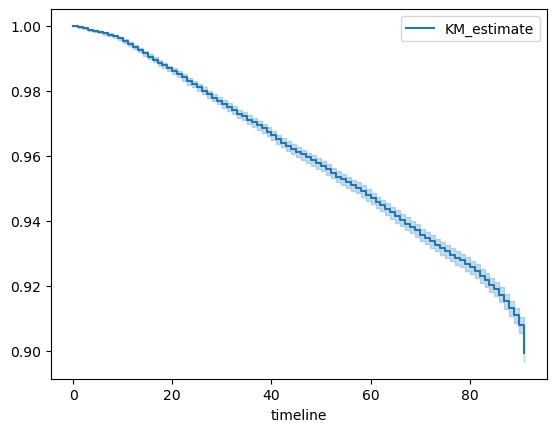

In [141]:
kmf.plot_survival_function()